In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import warnings
from IPython.core.display import display, HTML

%matplotlib inline
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:85% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('max_colwidth', 100)
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 0)
# pd.reset_option('display.float_format')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%config InlineBackend.figure_format = 'retina'


## Links

https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d
https://github.com/pcm-dpc/COVID-19


In [2]:
base = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/"
fn = "dpc-covid19-ita-andamento-nazionale.csv"
national = pd.read_csv(f"{base}/{fn}")

national["timestamp"] = pd.to_datetime(national["data"])
national["dayofyear"] = national["timestamp"].dt.dayofyear
national["date"] = national["timestamp"].dt.date
national.iloc[-1,:].T

data                          2020-04-09T17:00:00
stato                                         ITA
ricoverati_con_sintomi                      28399
terapia_intensiva                            3605
totale_ospedalizzati                        32004
isolamento_domiciliare                      64873
totale_positivi                             96877
variazione_totale_positivi                   1615
nuovi_positivi                               4204
dimessi_guariti                             28470
deceduti                                    18279
totale_casi                                143626
tamponi                                    853369
note_it                                       NaN
note_en                                       NaN
timestamp                     2020-04-09 17:00:00
dayofyear                                     100
date                                   2020-04-09
Name: 45, dtype: object

In [3]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

def fit_sigmoind(df, verbose=False):
    
    x = list(df.iloc[:,0])
    y = list(df.iloc[:,1])
    fit = curve_fit(logistic_model,x,y,p0=[2,100,20000])

    # Estimates
    a = fit[0][0]
    b = fit[0][1]
    c = fit[0][2]

    # Standard Deviation from Covariant matrix
    err_a = np.sqrt(fit[1][0][0])
    err_b = np.sqrt(fit[1][1][1])
    err_c = np.sqrt(fit[1][2][2])
    
    if verbose:
        print(f"a = {round(a,4)}+-{round(err_a,4)}")
        print(f"b = {round(b,4)}+-{round(err_b,4)}")
        print(f"c = {round(c,4)}+-{round(err_c,4)}")
    
    output = [a, b, c]
    return output

,date,timestamp,dayofyear,tests,positives,dead,intensive_care,new_tests,new_positives,new_dead,infection_rate,mortality_rate,icu_rate,growth_rate,growth_rate_avg
0,2020-02-24,2020-02-24 18:00:00,55,4324,229,7,26,nan,nan,nan,5.296,3.057,11.354,nan,nan
1,2020-02-25,2020-02-25 18:00:00,56,8623,322,10,35,4299.000,93.000,3.000,3.734,3.106,10.870,nan,nan


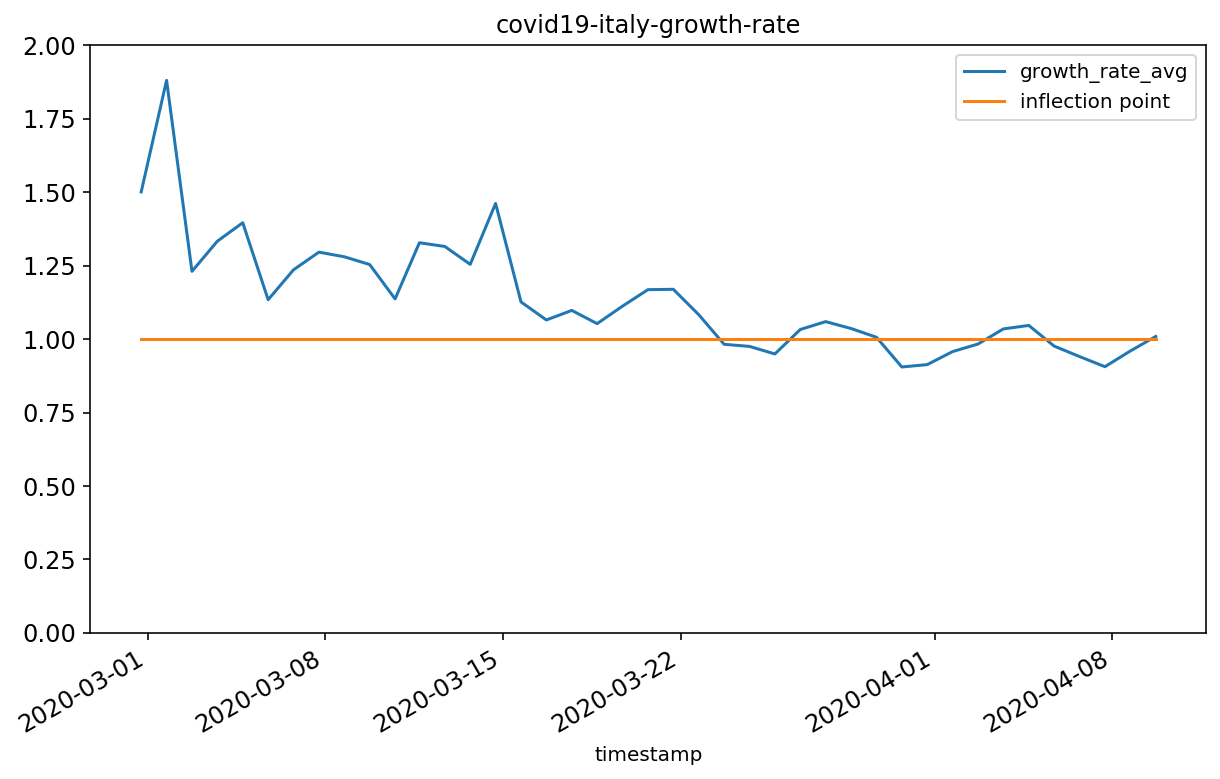

In [4]:
view = national[["date","timestamp", "dayofyear", "tamponi", "totale_casi", "deceduti", "terapia_intensiva"]]
view = view.rename(columns={"tamponi":"tests",
                                "totale_casi": "positives",
                                "deceduti": "dead",
                                "terapia_intensiva": "intensive_care"})

view["new_tests"] = view["tests"].diff()
view["new_positives"] = view["positives"].diff()
view["new_dead"] = view["dead"].diff()
view["infection_rate"] = view["positives"]/view["tests"]*100
view["mortality_rate"] = view["dead"]/view["positives"]*100
view["icu_rate"] = view["intensive_care"]/view["positives"]*100

## Growth Rate
view["growth_rate"] = view["new_positives"]/view["new_positives"].shift(1)
view = view.replace([np.inf, -np.inf], np.nan)

# Average across rolling window
view["growth_rate_avg"] = view["growth_rate"].rolling(4, win_type=None).mean()
view.head(2)


growth = view.set_index("timestamp")[["growth_rate_avg"]].dropna()
growth["inflection point"] = 1

# Plot and save
title = "covid19-italy-growth-rate"
ax = growth.plot(ylim=(0, 2), fontsize=12, title = title, figsize=(10,6))
fig = ax.get_figure()
fig.savefig(f"{title}.png")

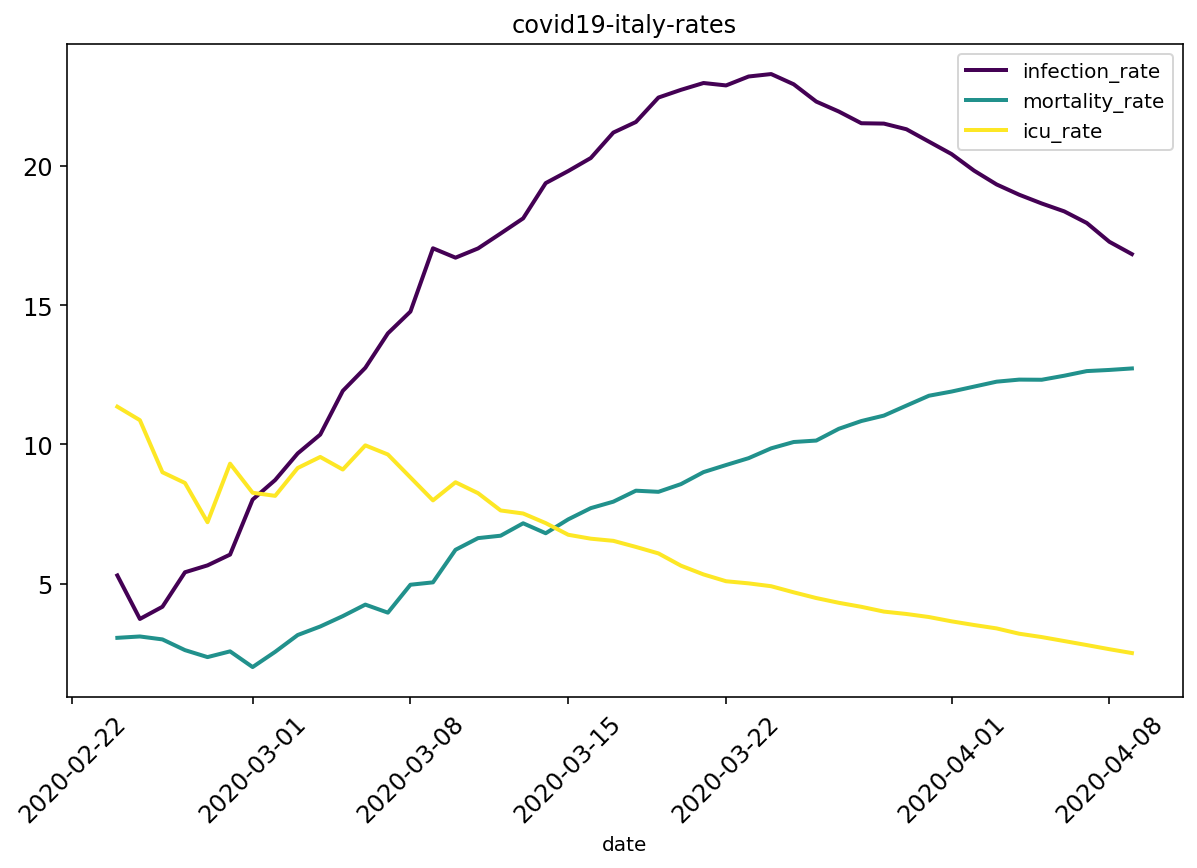

In [5]:
# Plot
title = "covid19-italy-rates"
to_plot = view.set_index("date")[["infection_rate", "mortality_rate", "icu_rate"]]
ax = to_plot.plot(title=title, linewidth=2, figsize=(10,6), rot=45, fontsize=12, colormap="viridis")

# Save
fig = ax.get_figure()
fig.savefig(f"{title}.png")

## Fit by Day

In [6]:
view.iloc[-1,:].T

date                        2020-04-09
timestamp          2020-04-09 17:00:00
dayofyear                          100
tests                           853369
positives                       143626
dead                             18279
intensive_care                    3605
new_tests                    46244.000
new_positives                 4204.000
new_dead                       610.000
infection_rate                  16.830
mortality_rate                  12.727
icu_rate                         2.510
growth_rate                      1.096
growth_rate_avg                  1.009
Name: 45, dtype: object

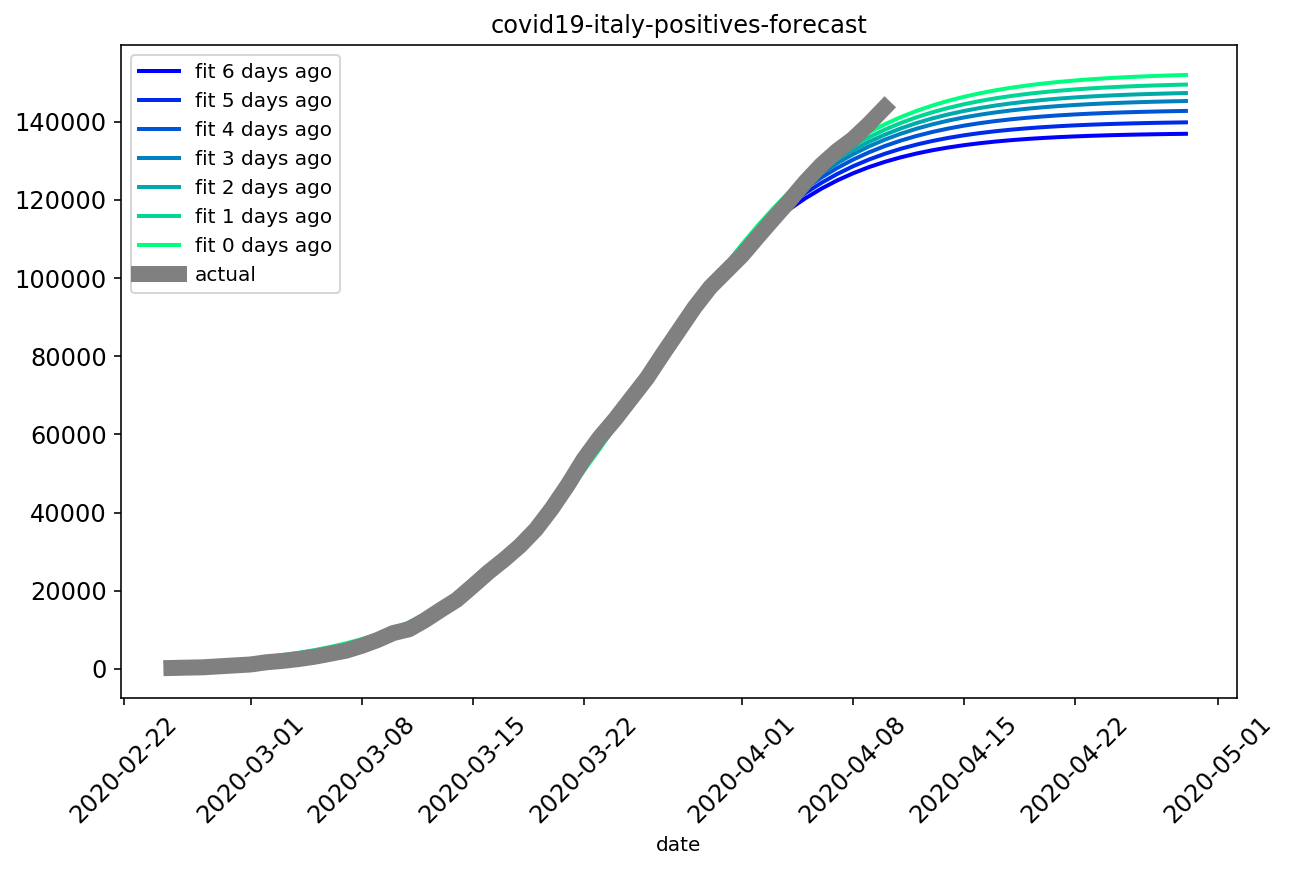

In [7]:
what = "positives"

x = list(range(55,120))
mdodels = pd.DataFrame()

for i in range(6,-1,-1):
    
    if i == 0:
        df = view[["dayofyear", what]]
    else:
        df = view[["dayofyear", what]].iloc[:-i, :]
    # Fit
    [a, b, c] = fit_sigmoind(df)
    # Eval
    yhat = [logistic_model(xi,a,b,c) for xi in x]
    
    mdodels["x"] = x
    mdodels[f"fit {i} days ago"] = yhat

mdodels = mdodels.set_index("x")

# to_plot = national["dayofyear", "totale_casi"]
measured_cases = pd.DataFrame({"x":x,"actual": np.nan})
measured_cases = measured_cases.set_index("x")
measured_cases.loc[list(view["dayofyear"]), "actual"]=list(view[what])

to_plot = pd.merge(mdodels, measured_cases, left_index=True, right_index=True).reset_index()

# Convert to dates
to_plot["date"] = to_plot["x"].apply(lambda x: pd.Timestamp("2020-01-01") + pd.Timedelta(x, unit='d')).dt.date

# set index 
to_plot = to_plot.drop(columns=["x"]).set_index("date")

# plot
title="covid19-italy-positives-forecast"
ax = to_plot.drop(columns=["actual"]).plot(
    title=title, linewidth=2, figsize=(10,6), rot=45, fontsize=12, colormap="winter")
ax = to_plot[["actual"]].plot(linewidth=8, ax=ax, kind="line", color="grey", rot=45)

# Save
fig = ax.get_figure()
fig.savefig(f"{title}.png")

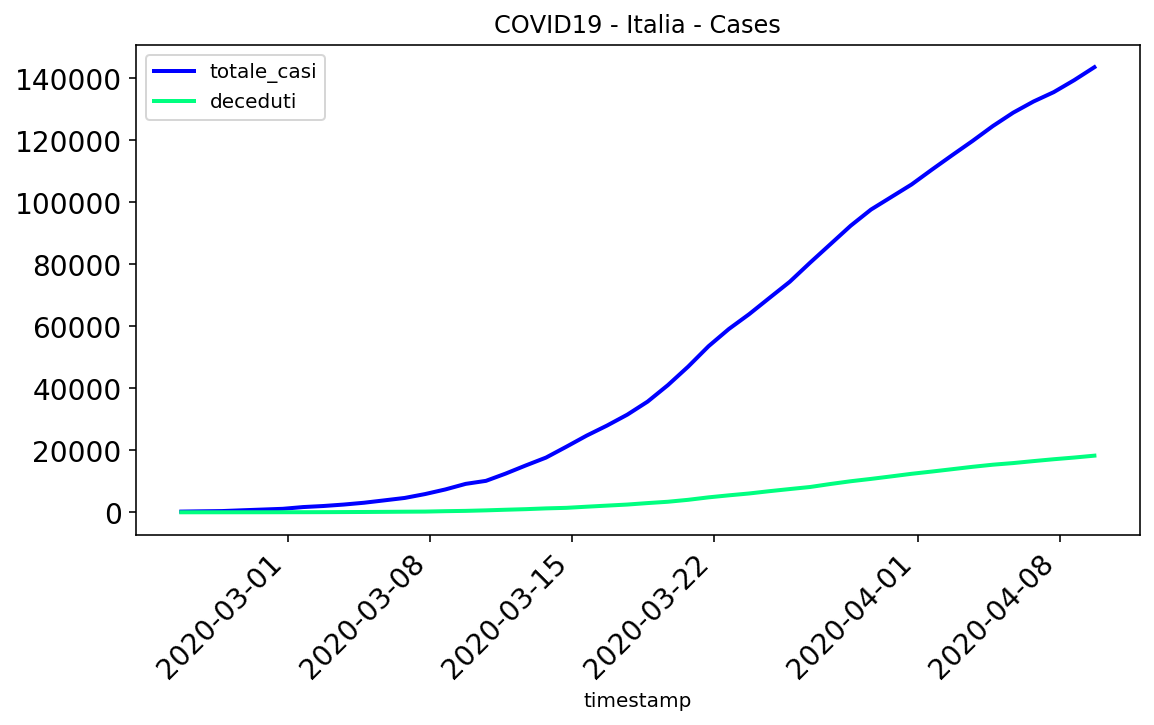

In [8]:
national.set_index("timestamp")[["totale_casi", "deceduti"]].plot(linewidth=2, 
                                    figsize=(9,5), 
                                    rot=45, 
                                    fontsize=14,
                                    colormap="winter",
                                    title="COVID19 - Italia - Cases")

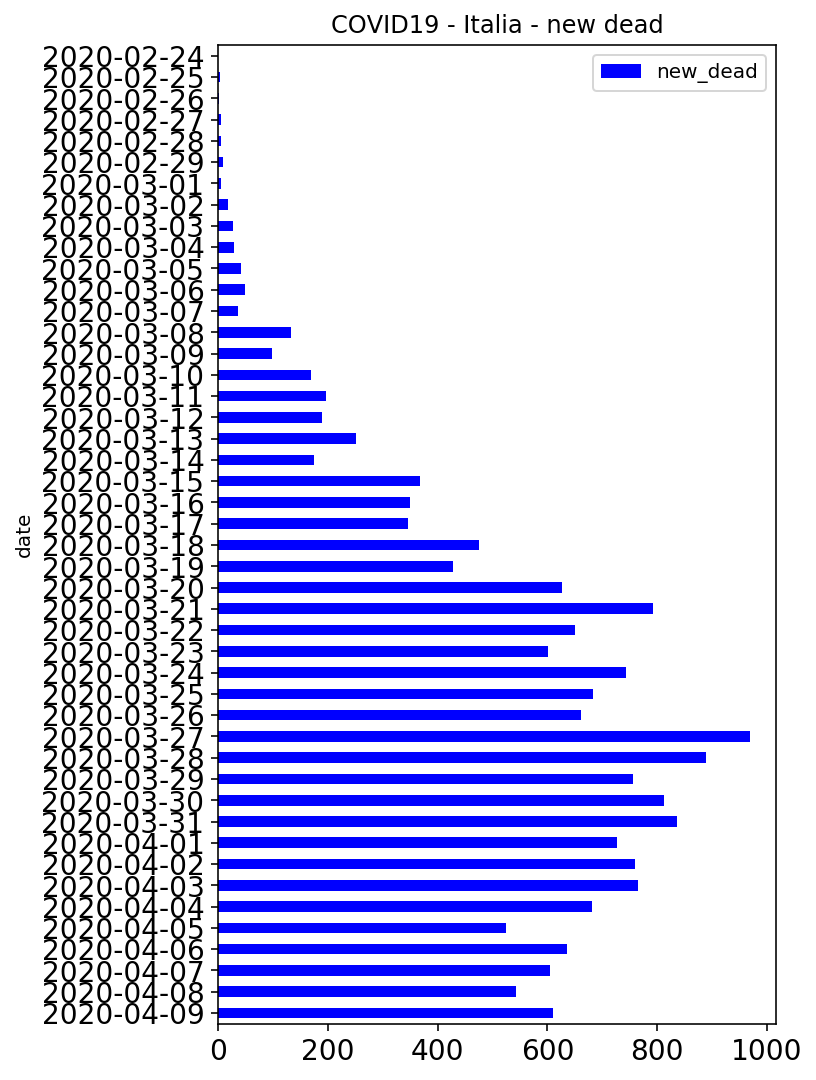

In [9]:
view.set_index("date")[["new_dead"]].sort_index(ascending=False).plot(linewidth=2, 
                                    figsize=(5,9), 
                                    rot=0, 
                                    fontsize=14,
                                    colormap="winter",
                                    title="COVID19 - Italia - new dead",
                                    kind="barh")

In [10]:
national

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en,timestamp,dayofyear,date
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,7,229,4324,NaN,NaN,2020-02-24 18:00:00,55,2020-02-24
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,10,322,8623,NaN,NaN,2020-02-25 18:00:00,56,2020-02-25
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,12,400,9587,NaN,NaN,2020-02-26 18:00:00,57,2020-02-26
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,17,650,12014,NaN,NaN,2020-02-27 18:00:00,58,2020-02-27
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,21,888,15695,NaN,NaN,2020-02-28 18:00:00,59,2020-02-28
5,2020-02-29T18:00:00,ITA,401,105,506,543,1049,228,240,50,29,1128,18661,NaN,NaN,2020-02-29 18:00:00,60,2020-02-29
6,2020-03-01T18:00:00,ITA,639,140,779,798,1577,528,566,83,34,1694,21127,NaN,NaN,2020-03-01 18:00:00,61,2020-03-01
7,2020-03-02T18:00:00,ITA,742,166,908,927,1835,258,342,149,52,2036,23345,NaN,NaN,2020-03-02 18:00:00,62,2020-03-02
8,2020-03-03T18:00:00,ITA,1034,229,1263,1000,2263,428,466,160,79,2502,25856,NaN,NaN,2020-03-03 18:00:00,63,2020-03-03
9,2020-03-04T18:00:00,ITA,1346,295,1641,1065,2706,443,587,276,107,3089,29837,NaN,NaN,2020-03-04 18:00:00,64,2020-03-04
